# Case - MV Optimization

## FINM 25000 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

#### Reference: *The Harvard Management Company and Inflation-Indexed Bonds*

***

# Setup

## Data

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,NaN,NaN,NaN
EFA,iShares MSCI EAFE ETF,ETF,USD,NaN,NaN,NaN
EEM,iShares MSCI Emerging Index Fun,ETF,USD,NaN,NaN,NaN
PSP,Invesco Global Listed Private E,ETF,USD,NaN,NaN,NaN
QAI,NYLI Hedge Multi-Strategy Track,ETF,USD,NaN,NaN,NaN
HYG,iShares iBoxx $ High Yield Corp,ETF,USD,NaN,NaN,NaN
DBC,Invesco DB Commodity Index Trac,ETF,USD,NaN,NaN,NaN
IYR,iShares U.S. Real Estate ETF,ETF,USD,"6,211,444.0000","3,480,166,144.0000",The fund seeks to track the investment results...
IEF,iShares 7-10 Year Treasury Bond,ETF,USD,"7,506,784.0000","34,938,195,968.0000",The underlying index measures the performance ...


## Functions that will be useful
### Basic performance metrics

In [4]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

### Tangency portfolio

In [5]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

***

# Performance Metrics

Start by looking at risk and performance of individual assets.

In [6]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,12.8%,14.3%,89.7%,-12.9%,12.7%
HYG,4.1%,7.6%,54.5%,-10.4%,8.6%
IYR,7.5%,16.9%,44.4%,-20.0%,13.3%
PSP,9.3%,21.3%,43.4%,-27.8%,17.9%
EFA,6.2%,15.1%,40.9%,-14.5%,14.3%
TIP,2.1%,5.1%,40.1%,-6.7%,4.3%
QAI,1.9%,4.9%,39.4%,-6.0%,3.7%
IEF,1.6%,6.3%,25.9%,-4.7%,4.7%
EEM,2.9%,17.6%,16.7%,-17.9%,16.3%
DBC,-0.5%,16.7%,-3.2%,-17.7%,10.3%


### Return Correlations

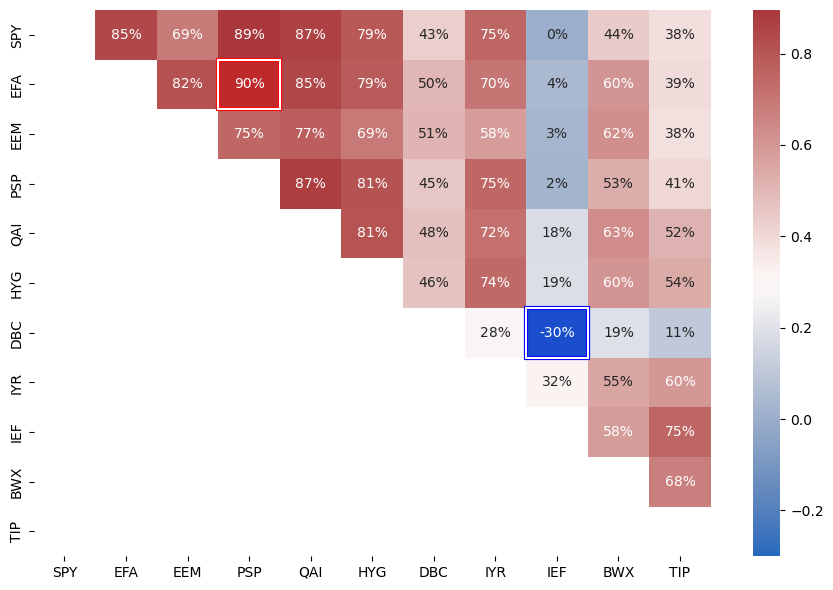

In [7]:
# compute corr, mask diagonal with NaN
corrmat = retsx.corr()
np.fill_diagonal(corrmat.values, np.nan)

# build a mask to hide the lower triangle (including diagonal)
mask = np.tril(np.ones_like(corrmat, dtype=bool))

# plot only the upper triangle heatmap
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    corrmat,
    mask=mask,            # hide lower portion
    annot=True,
    fmt='.0%',
    cmap='vlag',
    ax=ax
)

# locate max & min (ignoring NaNs)
arr = corrmat.values.astype(float)
max_pos = np.unravel_index(np.nanargmax(arr), arr.shape)
min_pos = np.unravel_index(np.nanargmin(arr), arr.shape)

# overlay highlights on those two cells
for (r, c), color in [(max_pos, 'red'), (min_pos, 'blue')]:
    # a) semi‐transparent fill
    ax.add_patch(plt.Rectangle(
        (c, r), 1, 1,
        facecolor=color,
        alpha=0.25,
        edgecolor=None,
        zorder=2
    ))
    # b) thick colored border
    ax.add_patch(plt.Rectangle(
        (c, r), 1, 1,
        fill=False,
        edgecolor=color,
        linewidth=3,
        zorder=3
    ))
    # c) thin white outline for extra pop
    ax.add_patch(plt.Rectangle(
        (c, r), 1, 1,
        fill=False,
        edgecolor='white',
        linewidth=1.5,
        zorder=4
    ))

plt.tight_layout()
plt.show()

In [8]:
max_r, max_c = max_pos
min_r, min_c = min_pos

# look up tickers
max_pair = (corrmat.index[max_r], corrmat.columns[max_c])
min_pair = (corrmat.index[min_r], corrmat.columns[min_c])

# print them (including the numeric value, if you like)
print(f"Max correlation is between {max_pair[0]} and {max_pair[1]}: {arr[max_r, max_c]:.1%}")
print(f"Min correlation is between {min_pair[0]} and {min_pair[1]}: {arr[min_r, min_c]:.1%}")

Max correlation is between EFA and PSP: 89.5%
Min correlation is between DBC and IEF: -30.0%


#### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. 
* TIPS outperformed Domestic bonds, `IEF`.
* TIPS outperformed International bonds, `BWX`.

Notably, 
* TIPS have very low correlation to the other assets.
* TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

***

# Tangency Portfolio

### The Tangency and the MV Frontier

Calculate the tangency portfolio
* weights
* excess returns
* performance metrics

For comparison, we show the performance metrics at the bottom of the previous performance table.

In [9]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

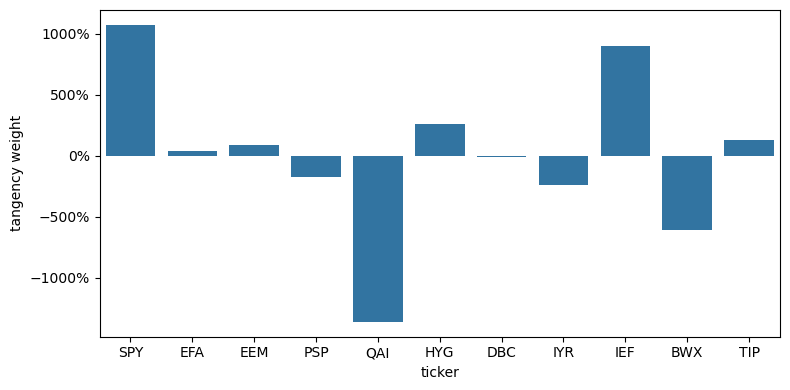

In [10]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=wts.index, y='tangency', data=wts, ax=ax)

# same formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.set_ylabel('tangency weight')
ax.set_xlabel('ticker')
plt.tight_layout()
plt.show()

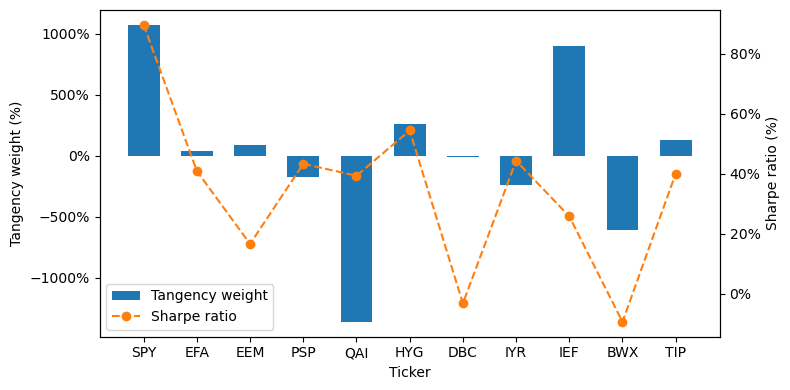

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

labels = wts.index.tolist()        
x      = np.arange(len(labels))    
width  = 0.6                       

fig, ax1 = plt.subplots(figsize=(8,4))
ax2      = ax1.twinx()

bars1 = ax1.bar(
    x,
    wts['tangency'],
    width,
    label='Tangency weight',
    color='C0'
)

line2, = ax2.plot(
    x,
    mets.loc[labels, 'Sharpe'],
    marker='o',
    linestyle='--',
    label='Sharpe ratio',
    color='C1'
)

ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Ticker')

ax1.set_ylabel('Tangency weight (%)')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax2.set_ylabel('Sharpe ratio (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower left')

plt.tight_layout()
plt.show()


In [12]:
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])
mets_tan = performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)
mets_tan.sort_values('Sharpe',ascending=False).style.format('{:.0%}')

,Mean,Vol,Sharpe,Min,Max
tangency,116%,74%,155%,-50%,73%
SPY,13%,14%,90%,-13%,13%
HYG,4%,8%,54%,-10%,9%
IYR,7%,17%,44%,-20%,13%
PSP,9%,21%,43%,-28%,18%
EFA,6%,15%,41%,-14%,14%
TIP,2%,5%,40%,-7%,4%
QAI,2%,5%,39%,-6%,4%
IEF,2%,6%,26%,-5%,5%
EEM,3%,18%,17%,-18%,16%


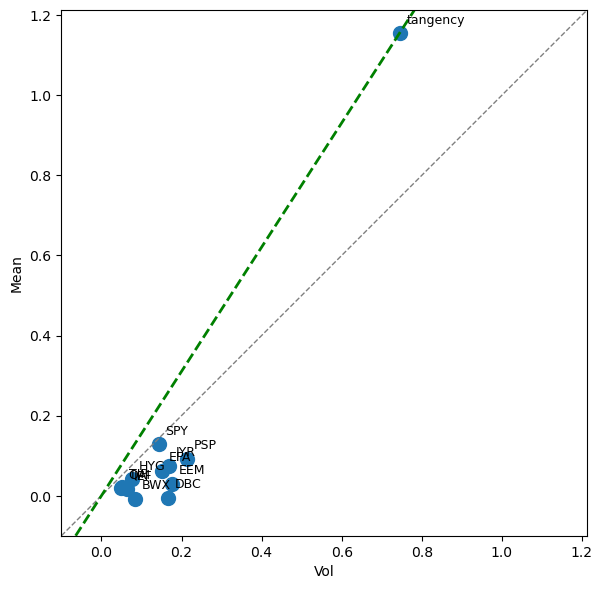

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

mets_tan.plot.scatter(x='Vol',y='Mean',ax=ax,s=100,xlim=(-.1,None),ylim=(-.1,None))

for idx, row in mets_tan.iterrows():
    ax.annotate(
        idx,                          # the label—here the DataFrame’s index
        (row['Vol'], row['Mean']),    # x,y coordinates
        textcoords="offset points",   # how to position the text
        xytext=(5,5),                 # offset in points (x,y)
        ha='left',                    # horizontal alignment
        va='bottom',                  # vertical alignment
        fontsize=9
    )

xlims = ax.get_xlim()
ylims = ax.get_ylim()
lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]

# 3) plot the 45° line (y = x)
ax.plot(lims, lims, linestyle='--', color='gray', linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)



t = mets_tan.loc['tangency']
tx, ty = t['Vol'], t['Mean']

# Method A: infinite line using ax.axline (Matplotlib ≥3.3)
ax.axline((0, 0), (tx, ty),
          color='green', linestyle='--', linewidth=2,
          label='Zero–Tangency line')


# 4) tidy up
ax.set_aspect('equal', 'box')   # optional: force true square aspect
plt.tight_layout()
plt.show()

### The Mean-Variance Frontier

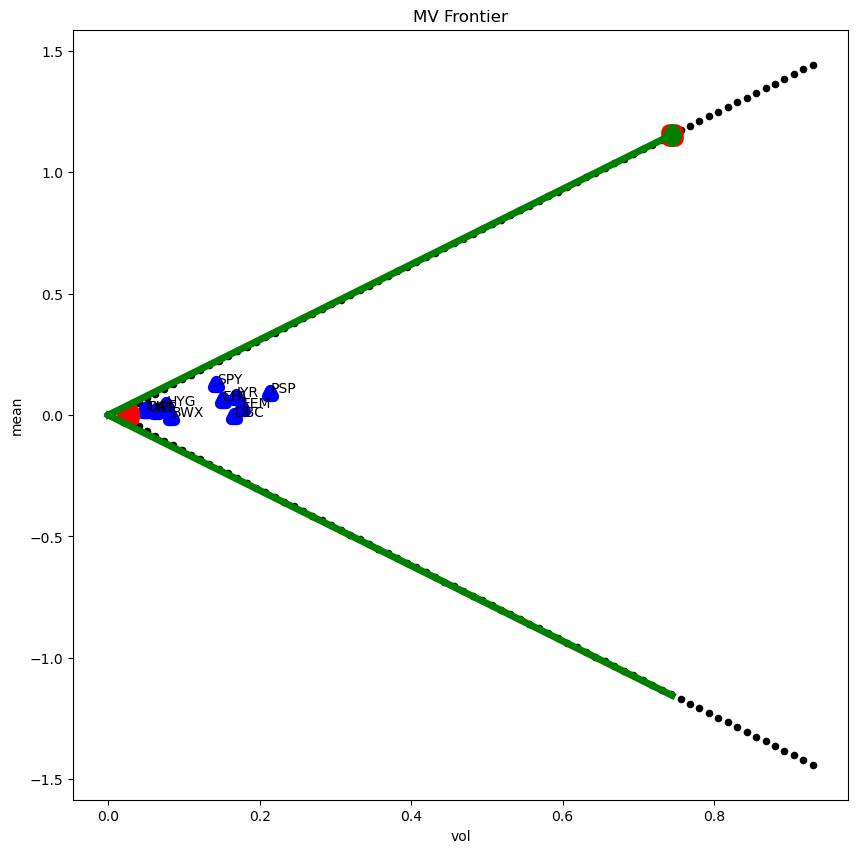

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute portfolios
omega_tan = tangency_weights(retsx)
vec_one_realized = retsx - retsx.mean() + 1
omega_gmv = tangency_weights(vec_one_realized)

omega = pd.concat([omega_tan, omega_gmv], axis=1)
omega.columns = ['tangency', 'gmv']

# build mv_frame without chained assignment
delta_grid = np.linspace(-1.25, 1.25, 150)
mv_frame = pd.DataFrame(columns=['mean','vol'], index=delta_grid)

for delta in delta_grid:
    omega_mv = delta * omega_tan + (1 - delta) * omega_gmv
    rets_p = retsx @ omega_mv
    mv_frame.loc[delta, 'mean'] = rets_p.mean().values[0] * 12
    mv_frame.loc[delta, 'vol']  = rets_p.std().values[0]  * np.sqrt(12)

# special returns
rets_special = pd.DataFrame(index=retsx.index)
rets_special['tan'] = retsx @ omega_tan.values
rets_special['gmv'] = retsx @ omega_gmv.values

# asset and special mv points
mv_assets = pd.concat([retsx.mean() * 12,
                       retsx.std()  * np.sqrt(12)], axis=1)
mv_assets.columns = ['mean','vol']

mv_special = pd.concat([rets_special.mean() * 12,
                        rets_special.std()  * np.sqrt(12)], axis=1)
mv_special.columns = ['mean','vol']

# plot frontier + assets + special points
ax = mv_frame.plot.scatter(x='vol', y='mean', c='k',
                           figsize=(10,10), title='MV Frontier')

mv_assets.plot.scatter(x='vol', y='mean', ax=ax,
                       c='b', marker='^', linewidth=8)

mv_special.plot.scatter(x='vol', y='mean', ax=ax,
                        c='r', marker='s', linewidth=12)

# label each asset safely
for name, row in mv_assets.iterrows():
    plt.text(x=row['vol'] + 0.0005,
             y=row['mean'] + 0.0005,
             s=name)

# tangency point in green diamond
rtan_temp = retsx @ tangency_weights(retsx)
pdtemp = pd.DataFrame([
    rtan_temp.mean().values * 12,
    rtan_temp.std().values * np.sqrt(12)
]).T
pdtemp.index = ['tangency']
pdtemp.columns = ['mean','vol']

pdtemp.plot.scatter(x='vol', y='mean', ax=ax,
                    c='g', marker='d', linewidth=10)

# green “line” from origin
xg = pdtemp.loc['tangency','vol']
yg = pdtemp.loc['tangency','mean']
plt.plot([0, xg], [0, yg],  color='green', linestyle='-', linewidth=5)
plt.plot([0, xg], [0, -yg], color='green', linestyle='-', linewidth=5)

plt.show()


***

# (In)Stability of the MV Frontier?

#### Weights if drop TIPS from investment set

In [15]:
wts_adj = wts[['tangency']].copy()

wts_adj['tangency ex tips'] = tangency_weights(retsx.drop(columns=['TIP']))
wts_adj.loc['TIP','tangency ex tips'] = 0

#### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [16]:
TIPS_ADJ = .01/12

retsx_adj = retsx.copy()
retsx_adj['TIP'] += TIPS_ADJ
wts_adj['tangency adj'] = tangency_weights(retsx_adj)

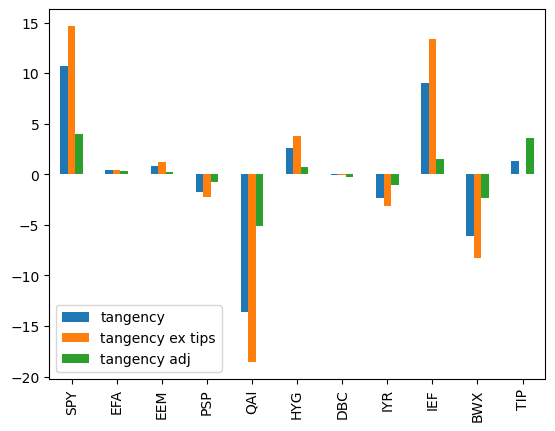

In [17]:
wts_adj.plot.bar();

In [18]:
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj']], annualization=12)
pd.concat([mets_tan.loc[['tangency']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,1.1551,0.7444,1.5517,-0.5036,0.7281
tangency adj,0.4772,0.2940,1.6233,-0.1778,0.3240


#### Uncertainty in mean returns
Note that our adjustment to the mean return of TIPS is not so large relative to the standard error of TIPS.

In [19]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.2%}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.2%}')

Standard error of mean of TIPS is equal to 0.11%
Proposed adjustment to mean of TIPS is  0.08%


### Conclusions on TIPS

* Dropping TIPS from the investment set barely impacts the weights or the resulting performance.
* Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

Based on just a mean-variance analysis, it seems one could reasonably go either way with TIPS as an alternate asset class. In the argument to keep it separate, there is more diversification between TIPS and bonds than between SPY and many other equity buckets Harvard has. On the other hand, TIPS mostly impact the allocation to domestic bonds and might be seen as another asset in that bucket.

***

# MV Optimization

In [20]:
TARG_MEAN = .01

In [21]:
wts['equal weights'] = 1/len(retsx.columns)
wts['risk parity'] = 1/retsx.var()
wts['regularized'] = tangency_weights(retsx,scale_cov=.5)

# rescale these to hit the target mean
wts *= TARG_MEAN / (retsx.mean()@wts)

In [22]:
performanceMetrics(retsx @ wts,annualization=12).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
tangency,12.0%,7.7%,155.2%,-5.2%,7.6%
equal weights,12.0%,27.0%,44.5%,-32.7%,21.9%
risk parity,12.0%,26.3%,45.5%,-27.3%,19.1%
regularized,12.0%,10.6%,113.5%,-7.5%,11.0%


***

# Out-of-Sample Testing

In [23]:
SPLIT0 = '2022'
SPLIT1 = '2023'

retsxIS = retsx.loc[:SPLIT0]
retsxOOS = retsx.loc[SPLIT1:]

retsxIS_adj = retsxIS.copy()
retsxIS_adj['TIP'] += TIPS_ADJ

wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)
wtsIS['tangency'] = tangency_weights(retsxIS)

tangency_ex_tips = tangency_weights(retsxIS.drop(columns=['TIP'])).values[:, 0]
wtsIS.loc[wtsIS.index[:-1], 'tangency ex tips'] = tangency_ex_tips
wtsIS.loc['TIP','tangency ex tips'] = 0

wtsIS['tan tips adj'] = tangency_weights(retsxIS_adj)
wtsIS['equal weights'] = 1/len(retsxIS.columns)
wtsIS['risk parity'] = 1/retsxIS.var()
wtsIS['regularized'] = tangency_weights(retsxIS,scale_cov=.5)

# rescale these to hit the target mean
wtsIS *= TARG_MEAN / (retsxIS.mean()@wtsIS)

In [24]:
import pandas as pd
from IPython.display import display

# 1) Pick a more contrasting highlight
oos_color = '#ffd54f'   # amber — works in both light & dark modes
text_color = 'black'    # force text to black for legibility

# 2) Data‐cell highlighter: background + text color
def highlight_oos(col):
    if col.name[0] == 'out-of-sample':
        return [f'background-color: {oos_color}; color: {text_color}'] * len(col)
    else:
        return [''] * len(col)

# 3) Build your two‐level DataFrame
perf_IS_OOS = pd.concat(
    [
        performanceMetrics(retsxIS @ wtsIS, annualization=12),
        performanceMetrics(retsxOOS @ wtsIS, annualization=12)
    ],
    keys=['in-sample', 'out-of-sample'],
    axis=1
)

# 4) Find the positions of the out‐of‐sample columns in the flat index
oos_positions = [
    i for i, (lvl0, lvl1) in enumerate(perf_IS_OOS.columns)
    if lvl0 == 'out-of-sample'
]

# 5) Build header styles (level0 & level1) with matching bg + text color
header_styles = []
for pos in oos_positions:
    for level in (0, 1):
        header_styles.append({
            'selector': f'th.col_heading.level{level}.col{pos}',
            'props': [
                ('background-color', oos_color),
                ('color', text_color),
            ]
        })

# 6) Put it all together
styled = (
    perf_IS_OOS
      .style
      .format('{:.1%}')
      .apply(highlight_oos, axis=0)                  # shade data cells
      .set_table_styles(header_styles, overwrite=False)  # shade headers
)

# 7) Display in your notebook
display(styled)


***

# Addendum: No Risk-Free Rate

### Tangency with and without a risk-free rate

Consider how similar are the tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [30]:
rets_special_riskfree = rets_special.copy()
mv_special_riskfree = mv_special.copy()

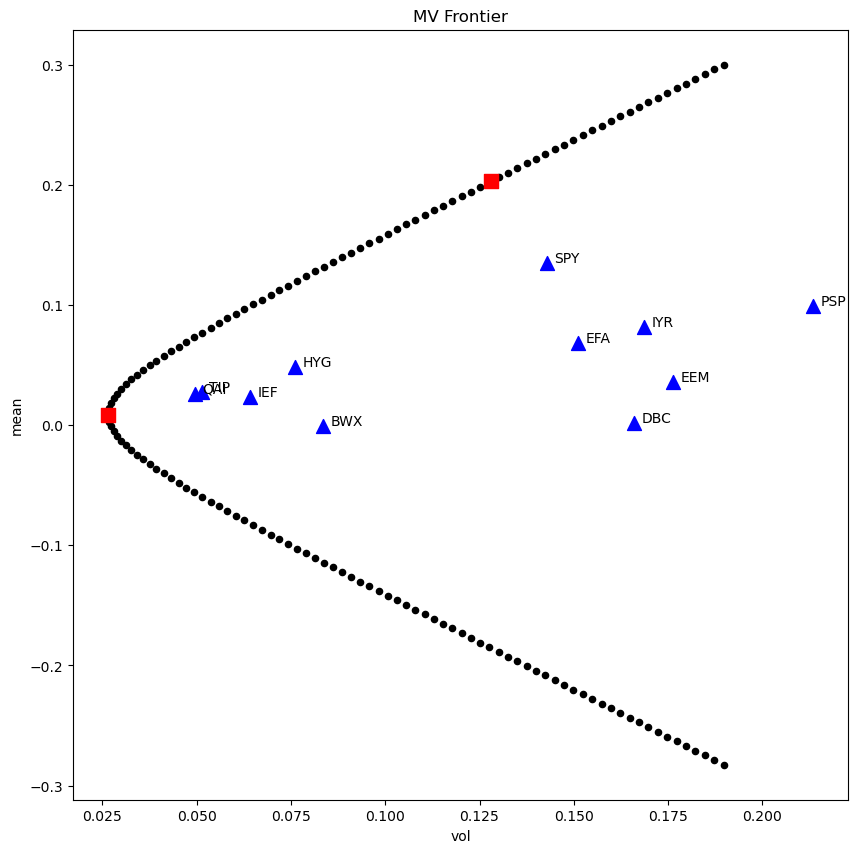

In [31]:
# compute weights
omega_tan = tangency_weights(rets)
rets_adj = rets.sub(rets.mean(), axis='columns').add(1)
omega_gmv = tangency_weights(rets_adj)

omega = pd.concat([omega_tan, omega_gmv], axis=1)
omega.columns = ['tangency', 'gmv']

# build the MV frontier 
delta_grid = np.linspace(-1.5, 1.5, 150)
mv_frame = pd.DataFrame(index=delta_grid, columns=['mean', 'vol'], dtype=float)

for delta in delta_grid:
    ω = delta * omega['tangency'] + (1 - delta) * omega['gmv']
    rets_p = rets.dot(ω)                
    μ = rets_p.mean() * 12
    σ = rets_p.std() * np.sqrt(12)
    mv_frame.loc[delta, 'mean'] = μ     
    mv_frame.loc[delta, 'vol']  = σ

# special portfolios
rets_special = pd.DataFrame({
    'tan': rets.dot(omega['tangency']),
    'gmv': rets.dot(omega['gmv'])
}, index=rets.index)

mv_assets = pd.DataFrame({
    'mean': rets.mean() * 12,
    'vol':  rets.std() * np.sqrt(12)
})

mv_special = pd.DataFrame({
    'mean': rets_special.mean() * 12,
    'vol':  rets_special.std() * np.sqrt(12)
})

# plot
ax = mv_frame.plot.scatter(
    x='vol', y='mean', c='k', figsize=(10,10), title='MV Frontier'
)
mv_assets.plot.scatter(
    x='vol', y='mean', ax=ax, c='b', marker='^', s=100
)
mv_special.plot.scatter(
    x='vol', y='mean', ax=ax, c='r', marker='s', s=100
)

# label using .iterrows()
for name, row in mv_assets.iterrows():
    plt.text(
        x = row['vol']  + 0.002,
        y = row['mean'] + 0.0005,
        s = str(name)
    )

plt.show()

The tangency portfolios are very similar, whether including a risk-free rate or not.
* tangency (to 0)
* tangency (to risk-free rate)

In [32]:
temp = pd.concat([mv_special_riskfree,mv_special],keys=['excess','total'],axis=1).loc['tan',:].to_frame()['tan'].unstack(level=1)
temp.style.format('{:.1%}').set_caption('Tangency portfolio: excess vs total returns')

,mean,vol
excess,115.5%,74.4%
total,20.3%,12.8%


In [33]:
rho = pd.concat([rets_special,rets_special_riskfree],axis=1).corr()
tab = pd.DataFrame([rho.loc['tan','tan'].iloc[0,1]], index=['tan'], columns=['rho'])
tab.style.format('{:.1%}')

,rho
tan,98.5%


***